# Basic EDA of Datasets

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# For NLP vectorizing
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

from wordcloud import WordCloud, STOPWORDS
from src.helpers import *
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
from sklearn.model_selection import train_test_split
import pickle

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import recall_score, precision_score, log_loss, accuracy_score, roc_auc_score
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier
from sklearn.naive_bayes import MultinomialNB

import statsmodels.api as sm
from scipy.stats import norm, t
from sklearn.metrics import mean_squared_error, r2_score, confusion_matrix
from sklearn.linear_model import LinearRegression, LogisticRegression, PassiveAggressiveClassifier, LogisticRegressionCV
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.inspection import plot_partial_dependence

### Kaggle data is labeled by Politifact.com 

In [5]:
# import kaggle data
kaggle_real = pd.read_csv('data/kaggle_news/True.csv')
kaggle_fake = pd.read_csv('data/kaggle_news/Fake.csv')

In [6]:
# label real news as 1 and fake news as 0

kaggle_real['label'] = 1
kaggle_fake['label'] = 0

In [7]:
# extra labeled data from outside source data-flair.training (unknown data source)
extra = pd.read_csv('data/extra_news.csv')

In [8]:
kaggle_fake.shape

(23481, 5)

In [9]:
kaggle_real.shape

(21417, 5)

In [10]:
# merging real and fake data into one dataset
news = pd.concat([kaggle_fake, kaggle_real]).reset_index(drop = True)

In [11]:
news.head()

,title,text,subject,date,label
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",0
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",0
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",0
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",0
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",0


In [12]:
news['char_count'] = news.text.apply(lambda x: len(x))

In [13]:
news['word_count'] = news.text.apply(lambda x: len(x.split()))

In [14]:
news.char_count.mean()

2469.1096930820972

In [15]:
# average length of real articles
news[news.label == 1]['word_count'].mean()

385.6400989867862

In [16]:
# average length of fake articles
news[news.label == 0]['word_count'].mean()

423.1979046888974

In [17]:
# visualize class balance

balance = news.label.value_counts()
balance

0    23481
1    21417
Name: label, dtype: int64

<BarContainer object of 2 artists>

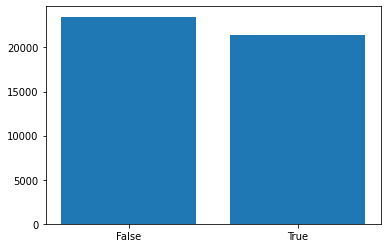

In [18]:
# notice similar class balance

plt.bar(balance.index, balance.values, tick_label = ['False', 'True'])

In [19]:
subjects_real = news[news['label'] == 0]['subject'].value_counts()
subjects_fake = news[news['label'] == 0]['subject'].value_counts()
subjects_real

News               9050
politics           6841
left-news          4459
Government News    1570
US_News             783
Middle-east         778
Name: subject, dtype: int64

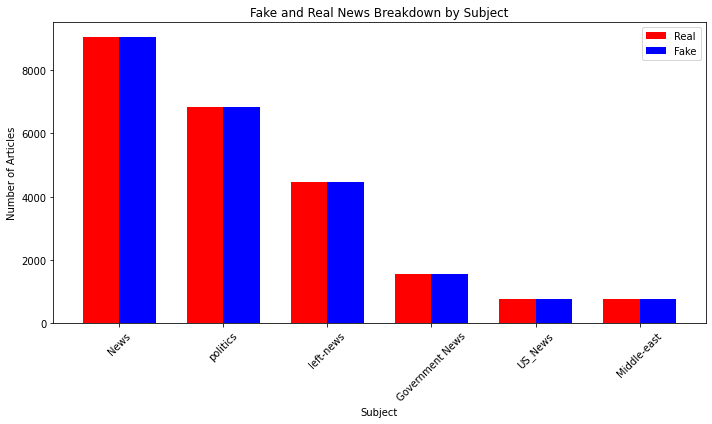

In [20]:
fig, ax = plt.subplots(1, figsize = (10, 6))

labels = subjects_real.index
x = np.arange(len(labels))
width = 0.35

ax.bar(x - width/2, subjects_real.values, width, label = 'Real', color = 'r')
ax.bar(x + width/2, subjects_fake.values, width, label = 'Fake', color = 'b')

ax.set_xticks(x)
ax.set_xticklabels(labels)

plt.title('Fake and Real News Breakdown by Subject')
plt.ylabel('Number of Articles')
plt.xlabel('Subject')
plt.rc('xtick', labelsize=13) 
plt.xticks(rotation =45)
plt.rc('ytick', labelsize=17) 
plt.rc('axes', titlesize=20)
plt.rc('axes', labelsize = 17)
plt.legend()
plt.tight_layout()
# plt.savefig('images/subject_breakdown.jpg')

# Creating NLP Vectors

In [21]:
# splitting the data

#split data into target and features, stratify to maintain class balance
y = news['label']
X = news['text']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [16]:
y_train.shape

(35918,)

In [17]:
X_train.shape

(35918,)

In [18]:
# # Validation Split  (Using cross validation instead)

# X_valtrain, X_valtest, y_valtrain, y_valtest = train_test_split(X_train, y_train, test_size=0.2, random_state=1, stratify=y_train)


In [19]:
# Demonstrating Preprocessor

doc = 'Hello!!! I am a TEST arTicle       *** ^^ that demonstrates how the text preprocessor works. It is a lovely, sunny day outside with green trees and many colored birds.'

preprocessor(doc)

'hello i be a test article that demonstrate how the text preprocessor work it be a lovely sunny day outside with green tree and many color bird'

In [20]:
# count vectorizer with bigrams and trigrams, top 100,000 most frequent tokens
cv = CountVectorizer(preprocessor=preprocessor, stop_words=stopwords_list(), ngram_range=(1, 3), max_features=100000)
cv_train_model = cv.fit(X_train)

In [21]:
# transform data to get counts of words
cv_X_train = cv_train_model.transform(X_train)
features = cv.get_feature_names()
word_count_df = pd.DataFrame(cv_X_train.toarray(), columns=features)

In [22]:
word_count_df.shape

(35918, 100000)

In [23]:
# alternate method
cv_X_train_df = cv_X_train.todense()
columns = sorted(cv_train_model.vocabulary_, key=lambda k: cv_train_model.vocabulary_[k])
cv_X_train_df = pd.DataFrame(cv_X_train_df, columns=columns);

In [24]:
cv_X_train_df.shape

(35918, 100000)

In [25]:
# top 20 highest count of words for real news

np.sum(cv_X_train_df[np.array(y_train)==1], axis=0).sort_values(ascending=False)[:10]

say           90735
trump         44092
state         29938
would         25190
reuters       23148
president     22907
year          17829
republican    17656
government    15974
house         13781
dtype: int64

In [26]:
# Term frequency-Inverse document frequency vectorizer with bigrams and trigrams, top 100,000 highest weighted tokens
tfidf = TfidfVectorizer(preprocessor=preprocessor, stop_words=stopwords_list(), ngram_range=(1, 3), max_features=100000)
tfidf_train_model = tfidf.fit(X_train)


In [27]:
# # save the training model
# with open('tfidf_train_model.pkl', 'wb') as f:
#     pickle.dump(tfidf_train_model, f)

In [28]:
# vocabulary
sorted(tfidf_train_model.vocabulary_.items(), key=lambda x: x[1], reverse=True)[:20]


[('zurich reuters', 99999),
 ('zurich', 99998),
 ('zuma say', 99997),
 ('zuma guptas deny', 99996),
 ('zuma guptas', 99995),
 ('zuma former', 99994),
 ('zuma', 99993),
 ('zulia state', 99992),
 ('zulia', 99991),
 ('zuckerberg say', 99990),
 ('zuckerberg', 99989),
 ('zucker', 99988),
 ('zor province', 99987),
 ('zor city', 99986),
 ('zor', 99985),
 ('zoomph', 99984),
 ('zoo', 99983),
 ('zones', 99982),
 ('zone would', 99981),
 ('zone syria', 99980)]

In [29]:
# transform the data using the tfidf vectorizer
tfidf_X_train = tfidf_train_model.transform(X_train)

In [30]:
# tfidf dataframe
tfidf_X_train_df = tfidf_X_train.todense()
columns = sorted(tfidf_train_model.vocabulary_, key=lambda k: tfidf_train_model.vocabulary_[k])
tfidf_X_train_df = pd.DataFrame(tfidf_X_train_df, columns=columns);

In [31]:
# top 20 scoring words for real news

np.sum(tfidf_X_train_df[np.array(y_train)==1], axis=0).sort_values(ascending=False)[:10]


say           841.355465
trump         541.067084
state         381.744631
reuters       380.831829
president     312.431183
would         305.316186
republican    278.449815
government    266.650643
house         248.166914
year          235.860570
dtype: float64

In [32]:
# top 20 scoring words for fake news

np.sum(tfidf_X_train_df[np.array(y_train)==0], axis=0).sort_values(ascending=False)[:10]


trump        868.697439
say          370.175866
clinton      328.577763
people       302.729280
go           295.208577
obama        288.840402
president    286.673302
get          276.370834
hillary      270.167593
one          265.191800
dtype: float64

In [33]:
# # For final model

# tfidf = TfidfVectorizer(preprocessor=preprocessor, stop_words=stopwords_list())
# tfidf_model = tfidf.fit(X)
# tfidf_X = tfidf_train_model.transform(X)

# X_df = pd.DataFrame(vectorized_X.toarray())
# X_df.shape

In [34]:
# # reload training model

# with open('cv_train_model.pkl', 'rb') as f:
#     cv_model = pickle.load(f)

# Testing Classification Models

In [35]:
# Logistic Regression 5 folds

log_cross = cross_validate(LogisticRegression(max_iter = 400, random_state = 42), tfidf_X_train, y_train, scoring = ['accuracy', 'precision', 'recall'], n_jobs = -1)
log_cross.update((x, y.mean()) for x, y in log_cross.items())
log_cross

{'fit_time': 2.194135808944702,
 'score_time': 0.014825677871704102,
 'test_accuracy': 0.9872208400371205,
 'test_precision': 0.9848232932908239,
 'test_recall': 0.9884432558929458}

In [36]:
# Random Forest Classifier using trial and error parameters, rather than waiting for grid search

rfc = RandomForestClassifier(criterion='gini', max_depth = 200, n_estimators = 50, max_features = 'auto', oob_score = True, random_state=42).fit(tfidf_X_train, y_train)
print(rfc.oob_score_)

0.9880839690405925


In [37]:
feat_scores = pd.DataFrame({'Top 10 Important Features':rfc.feature_importances_}, index = columns)
#feat_scores.sort_values(by = 'Fraction of Samples Affected').plot(kind='barh');

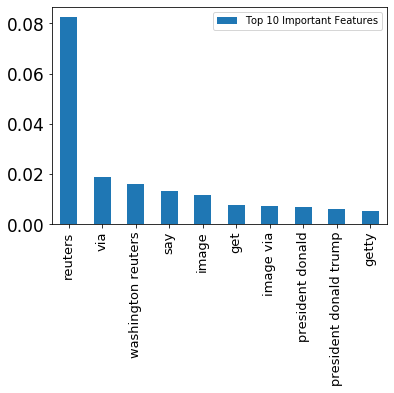

In [38]:
feat_scores.sort_values(by = 'Top 10 Important Features', ascending=False)[:10].plot(kind='bar');

### 'Reuters' giving off too much signal! It is a news service so lets find the distribution comparing its appearance in real and fake news.

In [39]:
cv_X_train_df.sum(axis=0).loc['reuters']

23478

In [40]:
reuters_fake_count = np.sum(cv_X_train_df[np.array(y_train)==0], axis=0).loc['reuters']
reuters_fake_count

330

In [41]:
reuters_real_count = np.sum(cv_X_train_df[np.array(y_train)==1], axis=0).loc['reuters']
reuters_real_count

23148

In [42]:
reuters_real_count / (reuters_real_count + reuters_fake_count)

0.9859442882698697

In [43]:
reuters_fake_count / (reuters_real_count + reuters_fake_count)

0.014055711730130335

99% of the real data has 'reuters' in it and 1% of the fake data has 'reuters' in it

In [44]:
image_fake_count = np.sum(cv_X_train_df[np.array(y_train)==0], axis=0).loc['image']
image_fake_count

11090

In [45]:
image_real_count = np.sum(cv_X_train_df[np.array(y_train)==1], axis=0).loc['image']
image_real_count

467

In [46]:
say_real_count = np.sum(cv_X_train_df[np.array(y_train)==1], axis=0).loc['say']
say_real_count

90735

In [47]:
say_fake_count = np.sum(cv_X_train_df[np.array(y_train)==0], axis=0).loc['say']
say_fake_count

39135

In [48]:
# random forest classifier 5 folds

rfc_cross = cross_validate(RandomForestClassifier(criterion='gini', max_depth = 200, n_estimators = 50, max_features = 'auto', oob_score = True, random_state=42),
                                                    tfidf_X_train, y_train, scoring = ['accuracy', 'precision', 'recall'],cv=5, n_jobs=-1)
rfc_cross.update((x, y.mean()) for x, y in rfc_cross.items())
rfc_cross

{'fit_time': 27.829764795303344,
 'score_time': 0.7977253437042237,
 'test_accuracy': 0.9915362599828164,
 'test_precision': 0.9899851322645356,
 'test_recall': 0.9922954982504752}

In [49]:
# gradient boosted Classifier 5 folds

gradient_cross = cross_validate(GradientBoostingClassifier(random_state = 42), tfidf_X_train, y_train, scoring = ['accuracy', 'precision', 'recall'],cv=5, n_jobs=-1)
gradient_cross.update((x, y.mean()) for x, y in gradient_cross.items())
gradient_cross

{'fit_time': 257.63558464050294,
 'score_time': 0.07884726524353028,
 'test_accuracy': 0.9954340155098945,
 'test_precision': 0.9937220930059683,
 'test_recall': 0.9967314436318435}

In [50]:
# Naive Bayes Classifier 5 Folds

nb_cross = cross_validate(MultinomialNB(alpha=0.1), tfidf_X_train, y_train, scoring = ['accuracy', 'precision', 'recall'],cv=5, n_jobs=-1)
nb_cross.update((x, y.mean()) for x, y in nb_cross.items())
nb_cross

{'fit_time': 0.11124873161315918,
 'score_time': 0.019825029373168945,
 'test_accuracy': 0.9622194757666813,
 'test_precision': 0.961778480234908,
 'test_recall': 0.9589097498641926}

## Removing Certain Features and Retraining the vectors

In [19]:
# Term frequency-Inverse document frequency vectorizer with bigrams and trigrams, top 100,000 highest weighted tokens
tfidf2 = TfidfVectorizer(preprocessor=preprocessor, stop_words=stopwords_list() + ['reuters'], ngram_range=(1, 3), max_features=10000)
tfidf_X_train_2 = tfidf2.fit_transform(X_train)


In [55]:
# # save the training model
# with open('../tfidf_train_model.pkl', 'wb') as f:
#     pickle.dump(tfidf_train_model, f)

In [19]:
# # reload training model

# with open('../tfidf_train_model.pkl', 'rb') as f:
#     tfidf_train_model2 = pickle.load(f)

In [29]:
# tfidf_X_train_2 = tfidf_train_model2.transform(X_train)

In [ ]:
# from scipy import sparse

# columns = sorted(tfidf2.vocabulary_, key=lambda k: tfidf2.vocabulary_[k])
# x_new = sparse.lil_matrix(sparse.csr_matrix(tfidf_X_train_2)[:,columns])

In [20]:
# tfidf dataframe
tfidf_X_train_2_df = tfidf_X_train_2.todense()
columns = sorted(tfidf2.vocabulary_, key=lambda k: tfidf2.vocabulary_[k])
tfidf_X_train_2_df = pd.DataFrame(tfidf_X_train_2_df, columns=columns);

In [21]:
# Random Forest Classifier using trial and error parameters, rather than waiting for grid search

rfc = RandomForestClassifier(criterion='gini', max_depth = 200, n_estimators = 50, max_features = 'auto', oob_score = True, random_state=42).fit(tfidf_X_train_2, y_train)
print(rfc.oob_score_)

0.9769474915084359


In [22]:
columns = sorted(tfidf2.vocabulary_, key=lambda k: tfidf2.vocabulary_[k])
feat_scores = pd.DataFrame({'Top 10 Important Features':rfc.feature_importances_}, index = columns)
#feat_scores.sort_values(by = 'Fraction of Samples Affected').plot(kind='barh');

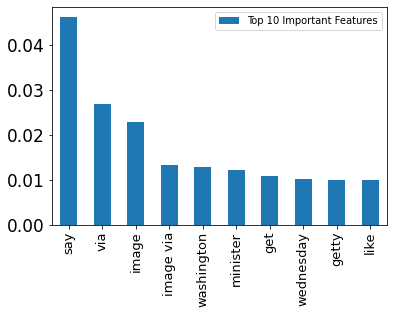

In [23]:
feat_scores.sort_values(by = 'Top 10 Important Features', ascending=False)[:10].plot(kind='bar');

In [ ]:
# # Partial Dependence Plot (reduce features or else breaks kernel)
# features = ['via','say','image']
# plot_partial_dependence(rfc, tfidf_X_train_df.sample(frac=.1), features, n_jobs=-1)
# fig = plt.gcf()

In [120]:
# Testing on holdout set from train-test split

X_test_tfidf = tfidf2.transform(X_test)
y_hat = rfc.predict(X_test_tfidf)
accuracy_score(y_test, y_hat)

0.9846325167037862

#### I suspect an overfitting to this dataset, lets test with the extra data

In [86]:
# extra dataset outside news articles to test on
extra.head()

,Unnamed: 0,title,text,label
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL


In [87]:
extra['label'] = (extra['label'] == 'REAL')*1

In [88]:
extra.shape

(6335, 4)

In [89]:
extra.head()

,Unnamed: 0,title,text,label
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",0
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,0
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,1
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",0
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,1


In [90]:
# splitting the data

#split data into target and features, stratify to maintain class balance
y_extra = extra['label']
X_extra = extra['text']

In [91]:
# baseline of extra data
y_extra.sum() / len(y_extra)

0.5005524861878453

In [29]:
X_extra_tfidf = tfidf2.transform(X_extra)

In [30]:
rfc_y_hat = rfc.predict(X_extra_tfidf)

In [31]:
# the data shows some improvement but obviously very overfit to the particular kaggle dataset

accuracy_score(y_extra, rfc_y_hat)

0.5957379636937647

#### Yes, very obvious overfitting to this data, only about 10% increase in signal dectection from baseline

# Time to bring in More Data!

In [22]:
# original kaggle dataset

kaggle = news[['text', 'label']]

In [23]:
kaggle.head()

,text,label
0,Donald Trump just couldn t wish all Americans ...,0
1,House Intelligence Committee Chairman Devin Nu...,0
2,"On Friday, it was revealed that former Milwauk...",0
3,"On Christmas day, Donald Trump announced that ...",0
4,Pope Francis used his annual Christmas Day mes...,0


In [24]:
kaggle.label.mean()

0.47701456635039424

In [25]:
# data verified by politifact

politifact = pd.read_csv('data/politifact_data.csv')

In [26]:
politifact.head()

,Unnamed: 0,text,label
0,0,"If you pass the so-called Dream Act, it will b...",0
1,1,12 more hurricanes headed towards U.S.,0
2,2,NFL attendance and ratings are WAY DOWN. Borin...,0
3,5,Roy Moore fought for pay increases for politic...,0
4,6,The Graham-Cassidy health care bill does inclu...,0


In [27]:
politifact = politifact[['text', 'label']]

In [28]:
politifact.shape

(8325, 2)

In [29]:
# correct format
politifact.head()

,text,label
0,"If you pass the so-called Dream Act, it will b...",0
1,12 more hurricanes headed towards U.S.,0
2,NFL attendance and ratings are WAY DOWN. Borin...,0
3,Roy Moore fought for pay increases for politic...,0
4,The Graham-Cassidy health care bill does inclu...,0


In [30]:
# 42% of the data is fake news

politifact.label.mean()

0.43003003003003004

In [32]:
# data from the onion (only using actual onion data for fake news)
onion = pd.read_csv('data/OnionOrNot.csv')

In [33]:
# 1 is an onion article so must be changed to 0 to match with other datasets for fake
onion = onion[onion.label == 1]
onion.label = 0

In [34]:
# correct format
onion.head()

,text,label
0,Entire Facebook Staff Laughs As Man Tightens P...,0
2,Bold Move: Hulu Has Announced That They’re Gon...,0
3,Despondent Jeff Bezos Realizes He’ll Have To W...,0
4,"For men looking for great single women, online...",0
5,Kim Jong-Un Wonders If Nuclear Threats Distrac...,0


In [35]:
onion.shape

(9000, 2)

In [36]:
# load NYT data

NYT = pd.read_csv('data/NYT.csv')

In [37]:
# only taking NYT articles

NYT = NYT[NYT.publication == 'New York Times']

In [38]:
# only taking content and setting label to true

NYT = NYT[['content']]
NYT['label'] = 1

In [39]:
# rename content to text
NYT.rename(columns={"content": "text"}, inplace = True)

In [40]:
# correct format
NYT.head()

,text,label
0,WASHINGTON — Congressional Republicans have...,1
1,"After the bullet shells get counted, the blood...",1
2,"When Walt Disney’s “Bambi” opened in 1942, cri...",1
3,"Death may be the great equalizer, but it isn’t...",1
4,"SEOUL, South Korea — North Korea’s leader, ...",1


In [41]:
NYT.shape

(7803, 2)

In [42]:
# concat all datasets

df_all = pd.concat([kaggle, politifact, onion, NYT]).reset_index(drop = True)

In [43]:
df_all.to_csv('data/all_data.csv')

In [44]:
df_all.head()

,text,label
0,Donald Trump just couldn t wish all Americans ...,0
1,House Intelligence Committee Chairman Devin Nu...,0
2,"On Friday, it was revealed that former Milwauk...",0
3,"On Christmas day, Donald Trump announced that ...",0
4,Pope Francis used his annual Christmas Day mes...,0


In [45]:
df_all.shape

(70026, 2)

In [46]:
onion.shape[0]/df_all.shape[0]

0.12852369120041127

In [47]:
# new baseline

1 - df_all.label.mean()

0.5316025476251678

# Modeling on new dataframe

In [4]:
df_all = pd.read_csv('data/all_data.csv').reset_index(drop = True)

In [5]:
df_all = df_all[['text', 'label']]

In [17]:
df_all.isna().sum()

text     0
label    0
dtype: int64

In [6]:
# splitting the data

#split data into target and features, stratify to maintain class balance
y = df_all['label']
X = df_all['text']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [7]:
# Term frequency-Inverse document frequency vectorizer with bigrams and trigrams, top 100,000 highest weighted tokens
tfidf = TfidfVectorizer(preprocessor=preprocessor, stop_words=stopwords_list() + ['reuters'], ngram_range=(1, 3), max_features=20000)
tfidf_train_model = tfidf.fit(X_train)

In [8]:
# transform the data using the tfidf vectorizer
tfidf_X_train = tfidf_train_model.transform(X_train)

In [75]:
# tfidf dataframe
tfidf_X_train_df = tfidf_X_train.todense()
columns = sorted(tfidf_train_model.vocabulary_, key=lambda k: tfidf_train_model.vocabulary_[k])
tfidf_X_train_df = pd.DataFrame(tfidf_X_train_df, columns=columns);

In [76]:
# top 20 scoring words for real news

np.sum(tfidf_X_train_df[np.array(y_train)==1], axis=0).sort_values(ascending=False)[:10]


say           1676.184295
trump          968.013713
mr             910.231823
state          705.608364
would          567.743149
president      541.571570
year           506.819302
republican     460.990825
government     439.164161
new            426.238482
dtype: float64

In [77]:
# top 20 scoring words for fake news

np.sum(tfidf_X_train_df[np.array(y_train)==0], axis=0).sort_values(ascending=False)[:10]


trump        1267.586828
say           645.766184
clinton       464.823278
obama         455.094418
go            445.255040
people        441.957802
president     440.291120
get           436.131694
one           385.020201
hillary       382.753245
dtype: float64

In [78]:
# Logistic Regression 5 folds

log_cross = cross_validate(LogisticRegression(max_iter = 400, random_state = 42), tfidf_X_train, y_train, scoring = ['accuracy', 'precision', 'recall'], n_jobs = -1)
log_cross.update((x, y.mean()) for x, y in log_cross.items())
log_cross

{'fit_time': 2.4135854721069334,
 'score_time': 0.013965845108032227,
 'test_accuracy': 0.9271331667261691,
 'test_precision': 0.9452641397020989,
 'test_recall': 0.8963795731707318}

In [9]:
# random forest classifier 5 folds

rfc_cross = cross_validate(RandomForestClassifier(criterion='gini', max_depth = 100, n_estimators = 100, max_features = 'auto', oob_score = True, random_state=42),
                                                    tfidf_X_train, y_train, scoring = ['accuracy', 'precision', 'recall'],cv=5, n_jobs=-1)
rfc_cross.update((x, y.mean()) for x, y in rfc_cross.items())
rfc_cross

{'fit_time': 109.2871736049652,
 'score_time': 0.8163335800170899,
 'test_accuracy': 0.9273652267047483,
 'test_precision': 0.9593777547607407,
 'test_recall': 0.8823170731707318}

In [80]:
# gradient boosted Classifier 5 folds

gradient_cross = cross_validate(GradientBoostingClassifier(random_state = 42), tfidf_X_train, y_train, scoring = ['accuracy', 'precision', 'recall'],cv=5, n_jobs=-1)
gradient_cross.update((x, y.mean()) for x, y in gradient_cross.items())
gradient_cross

{'fit_time': 290.5793572902679,
 'score_time': 0.09346399307250977,
 'test_accuracy': 0.8958764726883256,
 'test_precision': 0.9012481979570207,
 'test_recall': 0.8734375}

In [81]:
# Naive Bayes Classifier 5 Folds

nb_cross = cross_validate(MultinomialNB(alpha=0.1), tfidf_X_train, y_train, scoring = ['accuracy', 'precision', 'recall'],cv=5, n_jobs=-1)
nb_cross.update((x, y.mean()) for x, y in nb_cross.items())
nb_cross

{'fit_time': 0.10827131271362304,
 'score_time': 0.021002721786499024,
 'test_accuracy': 0.8746340592645485,
 'test_precision': 0.8783375759970069,
 'test_recall': 0.8501143292682928}

In [35]:
# Grid Search RFC

parameters = {'criterion':('gini', 'entropy'), 'max_depth':[100,200,300], 'n_estimators':[10,50,100]} #max_depth 3 different times
rfc = RandomForestClassifier()
#gridsearch Cross Validate
gs = GridSearchCV(rfc, parameters, scoring = ['accuracy','precision'], refit='precision') 
# other scoring strings
# https://scikit-learn.org/stable/modules/model_evaluation.html #model-evaluation
# refit makes it the primary ranking score out of the list we gave
# n_jobs = -1 runs the process using all cores on your computer

gs.fit(tfidf_X_train, y_train)


GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'criterion': ('gini', 'entropy'),
                         'max_depth': [100, 200, 300],
                         'n_estimators': [10, 50, 100]},
             refit='precision', scoring=['accuracy', 'precision'])

In [36]:
#5 K-folds done by default

pd.DataFrame(gs.cv_results_).T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
mean_fit_time,10.1138,50.2015,97.3079,11.9103,60.9297,120.089,12.1121,61.7482,125.405,9.69765,46.9242,94.4472,11.9718,62.4021,121.479,12.5959,63.2365,129.649
std_fit_time,0.350329,1.54563,0.707187,0.396083,0.519858,4.43858,0.313177,1.15035,2.24362,0.45115,0.999656,2.17796,0.204473,2.73285,1.76705,0.232091,1.44242,1.20682
mean_score_time,0.111172,0.390923,0.714521,0.109938,0.436449,0.778295,0.109747,0.415217,0.817657,0.100462,0.34005,0.686683,0.108183,0.379529,0.71145,0.105602,0.387211,0.81502
std_score_time,0.0147697,0.0267132,0.0723736,0.0118875,0.034731,0.0433503,0.00749082,0.0366547,0.0426651,0.00726666,0.0135063,0.0274505,0.00358165,0.00839794,0.0172479,0.00922479,0.0042148,0.0786976
param_criterion,gini,gini,gini,gini,gini,gini,gini,gini,gini,entropy,entropy,entropy,entropy,entropy,entropy,entropy,entropy,entropy
param_max_depth,100,100,100,200,200,200,300,300,300,100,100,100,200,200,200,300,300,300
param_n_estimators,10,50,100,10,50,100,10,50,100,10,50,100,10,50,100,10,50,100
params,"{'criterion': 'gini', 'max_depth': 100, 'n_est...","{'criterion': 'gini', 'max_depth': 100, 'n_est...","{'criterion': 'gini', 'max_depth': 100, 'n_est...","{'criterion': 'gini', 'max_depth': 200, 'n_est...","{'criterion': 'gini', 'max_depth': 200, 'n_est...","{'criterion': 'gini', 'max_depth': 200, 'n_est...","{'criterion': 'gini', 'max_depth': 300, 'n_est...","{'criterion': 'gini', 'max_depth': 300, 'n_est...","{'criterion': 'gini', 'max_depth': 300, 'n_est...","{'criterion': 'entropy', 'max_depth': 100, 'n_...","{'criterion': 'entropy', 'max_depth': 100, 'n_...","{'criterion': 'entropy', 'max_depth': 100, 'n_...","{'criterion': 'entropy', 'max_depth': 200, 'n_...","{'criterion': 'entropy', 'max_depth': 200, 'n_...","{'criterion': 'entropy', 'max_depth': 200, 'n_...","{'criterion': 'entropy', 'max_depth': 300, 'n_...","{'criterion': 'entropy', 'max_depth': 300, 'n_...","{'criterion': 'entropy', 'max_depth': 300, 'n_..."
split0_test_accuracy,0.910925,0.922349,0.925116,0.909407,0.926544,0.927704,0.912978,0.926544,0.928597,0.910211,0.924134,0.924134,0.908247,0.926812,0.925027,0.905659,0.925652,0.92699
split1_test_accuracy,0.912263,0.931007,0.931096,0.911728,0.930203,0.931899,0.910835,0.930114,0.931185,0.913067,0.926187,0.929579,0.916101,0.928418,0.931453,0.911549,0.928954,0.928508


In [37]:
gs.best_estimator_

RandomForestClassifier(max_depth=100)

In [38]:
#best hyperparameters

gs.best_params_

{'criterion': 'gini', 'max_depth': 100, 'n_estimators': 100}

## Using validation split to plot a ROC curve

In [19]:
# Validation Split

X_valtrain, X_valtest, y_valtrain, y_valtest = train_test_split(X_train, y_train, test_size=0.2, random_state=1, stratify=y_train)

In [20]:
# Term frequency-Inverse document frequency vectorizer with bigrams and trigrams, top 20,000 highest weighted tokens
tfidf_val = TfidfVectorizer(preprocessor=preprocessor, stop_words=stopwords_list() + ['reuters'], ngram_range=(1, 3), max_features=20000)
tfidf_val_model = tfidf_val.fit(X_valtrain)


In [22]:
# transform the validation training data using the tfidf vectorizer
tfidf_X_valtrain = tfidf_val_model.transform(X_valtrain)

In [23]:
# transform the testing validation data using the tfidf vectorizer
tfidf_X_valtest = tfidf_val_model.transform(X_valtest)

In [28]:
rfc_val = RandomForestClassifier(criterion='gini', max_depth = 200, n_estimators = 50, max_features = 'auto', oob_score = True, random_state=42).fit(tfidf_X_valtrain, y_valtrain)
rfc_val_probs = rfc_val.predict_proba(tfidf_X_valtest)



In [25]:
lf_val = LogisticRegression(max_iter = 400, random_state = 42).fit(tfidf_X_valtrain, y_valtrain)
lf_val_probs = lf_val.predict_proba(tfidf_X_valtest)

In [26]:
gbc_val = GradientBoostingClassifier(random_state = 42).fit(tfidf_X_valtrain, y_valtrain)
gbc_val_probs = gbc_val.predict_proba(tfidf_X_valtest)

In [27]:
nb_val = MultinomialNB(alpha=0.1).fit(tfidf_X_valtrain, y_valtrain)
nb_val_probs = nb_val.predict_proba(tfidf_X_valtest)

In [113]:
rfc_val_probs

array([[0.14      , 0.86      ],
       [0.9631829 , 0.0368171 ],
       [0.06      , 0.94      ],
       ...,
       [0.82916294, 0.17083706],
       [0.96594692, 0.03405308],
       [0.92551262, 0.07448738]])

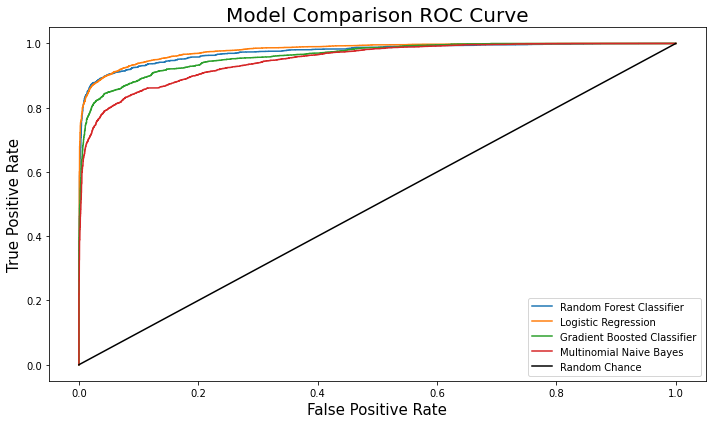

In [29]:
fig, ax = plt.subplots(1, figsize=(10,6))

rfc_df = calculate_threshold_values(rfc_val_probs[:,1], y_valtest)
plot_roc(ax, rfc_df, 'Random Forest Classifier')

lf_df = calculate_threshold_values(lf_val_probs[:,1], y_valtest)
plot_roc(ax, lf_df, 'Logistic Regression')

gbc_df = calculate_threshold_values(gbc_val_probs[:,1], y_valtest)
plot_roc(ax, gbc_df, 'Gradient Boosted Classifier')

nb_df = calculate_threshold_values(nb_val_probs[:,1], y_valtest)
plot_roc(ax, nb_df, 'Multinomial Naive Bayes')

ax.plot([0,1],[0,1], 'k', label="Random Chance")

ax.legend()
plt.tight_layout()
# plt.savefig('images/roc.jpg')

## RFC on Final Test Set

In [10]:
# Random Forest Classifier with params after using gridsearch

rfc = RandomForestClassifier(criterion='gini', max_depth = 100, n_estimators = 100, max_features = 'auto', oob_score = True, random_state=42).fit(tfidf_X_train, y_train)
print(rfc.oob_score_)

0.9290789003927169


In [83]:
feat_scores = pd.DataFrame({'Top 10 Important Features':rfc.feature_importances_}, index = columns)

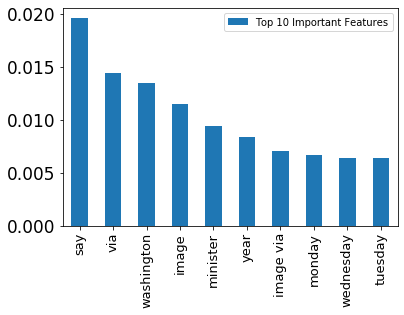

In [84]:
feat_scores.sort_values(by = 'Top 10 Important Features', ascending=False)[:10].plot(kind='bar');

In [11]:
# Testing on holdout set from train-test split

X_test_tfidf = tfidf.transform(X_test)
y_hat = rfc.predict(X_test_tfidf)
accuracy_score(y_test, y_hat)

0.9358132229044696

In [12]:
precision_score(y_test, y_hat)

0.9690140845070423

In [13]:
recall_score(y_test,y_hat)

0.8914634146341464

In [79]:
rfc_probs = rfc.predict_proba(X_test_tfidf)

In [80]:
rfc_probs.shape

(14006, 2)

In [19]:
confusion_matrix(y_hat, y_test)

array([[7208,  678],
       [ 238, 5882]])

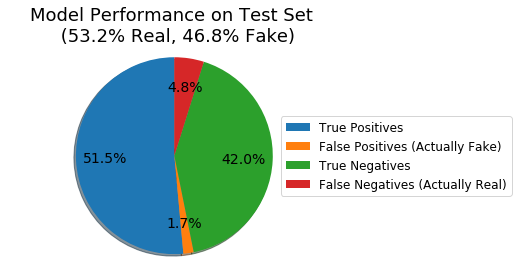

In [67]:
# Pie chart of confusion matrix
tp = (7208/14006) * 100
tn = (5882/14006) * 100
fp = (238/14006) * 100
fn = (678/14006) * 100

labels = 'True Positives', 'False Positives (Actually Fake)', 'True Negatives', 'False Negatives (Actually Real)'
sizes = [tp, fp, tn, fn]
explode = (0, 0, 0, 0)

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, autopct='%1.1f%%',
        shadow=True, startangle=90, pctdistance=0.7, textprops={'fontsize': 14})
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax1.legend(labels,
          loc="center left",
          bbox_to_anchor=(0.8, 0, 0.5, 1), fontsize = 12)
ax1.set_title("Model Performance on Test Set \n (53.2% Real, 46.8% Fake)", fontsize = 18)

plt.show()


In [190]:
df_all.shape

(70026, 2)

In [181]:
# kaggle (44898), politifact(8325), onion(9000), nyt(7803)

df_all[55001:55005]

,text,label
55001,Man Wasting His Life Playing Video Games When ...,0
55002,Ominous: The USDA Has Printed Gene Hackman’s N...,0
55003,News: UPDATE: Every Facebook User Who Clicked ...,0
55004,"Mom Hasn’t Said Full, Uninterrupted Sentence T...",0


In [191]:
# kaggle (44898), politifact(8325), onion(9000), nyt(7803)

df_all[26000:26005]

,text,label
26000,WASHINGTON (Reuters) - The chairman of the Sen...,1
26001,WASHINGTON (Reuters) - Top Republican lawmaker...,1
26002,WASHINGTON (Reuters) - President Donald Trump’...,1
26003,BERLIN (Reuters) - Plans under consideration i...,1
26004,MOSCOW (Reuters) - Draft new U.S. sanctions ag...,1


In [188]:
# Politifact Example

df_all['text'][26000]

'WASHINGTON (Reuters) - The chairman of the Senate Foreign Relations Committee said on Wednesday his panel was likely to strip out language imposing sanctions against North Korea from legislation that contains sanctions against Russia and Iran. Republican Senator Bob Corker told the Washington Post in an interview that doing so would ensure the measure could pass. Corker said the bill was likely to become law “very, very soon.” '

In [192]:
# kaggle (44898), politifact(8325), onion(9000), nyt(7803)

df_all[70000:70005]

,text,label
70000,"WEST PALM BEACH, Fla. — Donald J. Trump o...",1
70001,WASHINGTON — President Obama designated two...,1
70002,"For anyone who loves the spotlight, mothering ...",1
70003,Google is a top target for European regulators...,1
70004,SEATTLE — Some parents find peace of mind i...,1


In [194]:
# NYT Example

df_all['text'][70003]

'Google is a top target for European regulators and privacy watchdogs, who openly fear and distrust its dominance. The American tech giant’s search engine alone gobbles up roughly 90 percent of the European market. But a landmark court ruling intended to rein in Google has instead put it at the forefront of Europe’s enforcement of Internet privacy. That has upended conventional wisdom about the company and raised questions about the role of commercial interests in protecting people’s privacy, often with little or no transparency. In the almost two years since Europeans gained the “right to be forgotten” on the Internet, Google has passed judgment in over 418, 000 cases  —   roughly 572 a day  —   from people wanting links of certain search results to be removed, according to the company’’s records. It has approved fewer than half of those requests, all behind closed doors. Google’s total number of   judgments is double those of most of Europe’s biggest individual national authorities o

In [87]:
articles_probs_df = pd.DataFrame(data = {'text': X_test, 'pred':y_hat, 'actual':y_test, 'prob_fake': rfc_probs[:,0]})

In [111]:
articles_probs_df

,text,pred,actual,prob_fake
47248,The House of Representatives does not have a p...,0,1,0.693827
55109,"Whale Regrets Eating 290,000 Plastic Poker Chi...",0,0,0.938384
1529,Donald Trump thanked outgoing FBI Director Jam...,0,0,0.980000
2775,Kellyanne Conway tried to baffle George Stepha...,0,0,0.860000
30195,MOSCOW (Reuters) - Syrian President Bashar al-...,1,1,0.177826
...,...,...,...,...
14130,Has their ever been a more vengeful and hatefu...,0,0,0.840000
55648,"July 21, 1969",0,0,0.957736
40753,DUBAI (Reuters) - The United States said it la...,1,1,0.160000
27203,WASHINGTON (Reuters) - U.S. House of Represent...,1,1,0.040000


In [88]:
# kaggle (44898), politifact(8325), onion(9000), nyt(7803)

false_positives = articles_probs_df[(articles_probs_df.actual == 0) & (articles_probs_df.pred == 1)]

In [147]:
false_positives.text[11577]

'THE TRUTH IS MEXICO DEPENDS ON THE BILLIONS SENT BACK BY ILLEGALS:FROM THE WALL STREET JOURNAL FEB 1, 2017:MEXICO CITY Mexicans living abroad sent home a record amount of money in 2016, taking advantage of a strong U.S. labor market and a weakening Mexican peso amid worries about actions that the administration of U.S. President Donald Trump may take against immigrants or remittances.After a 25% jump in November, the month that Mr. Trump was elected, December remittances grew 6.2% from a year before to $2.34 billion, bringing the total for the year to $27 billion, the Bank of Mexico said Wednesday.'

In [90]:
# kaggle (44898), politifact(8325), onion(9000), nyt(7803)

true_negatives = articles_probs_df[(articles_probs_df.actual == 0) & (articles_probs_df.pred == 0)]

In [137]:
true_negatives.head(50)

,text,pred,actual,prob_fake
55109,"Whale Regrets Eating 290,000 Plastic Poker Chi...",0,0,0.938384
1529,Donald Trump thanked outgoing FBI Director Jam...,0,0,0.980000
2775,Kellyanne Conway tried to baffle George Stepha...,0,0,0.860000
47324,Health insurance companies deny 1 out of 5 tre...,0,0,0.802624
59908,Must See: Inspiring: This Teenager Is The Firs...,0,0,0.961138
11349,Conservative media company The Blaze has suspe...,0,0,0.680000
53812,Must See: Finally! Khan Academy Now Offers A C...,0,0,0.958525
45324,Says Hillary Clinton has spoken such lies abou...,0,0,0.802006
9879,The hateful Hollywood crowd just couldn t help...,0,0,0.558954
53694,Graduation Ceremony A Real Broken Fucking Reco...,0,0,0.953797


In [143]:
true_negatives.text[8044]

'Another person was attacked at a Trump rally in what has become a theme at Trump events since the billionaire businessman threw in his hat for the Republican nomination for the presidency.This time, a young Latina woman had a poster denouncing Trump s stance on immigration ripped out of her hand by two men. The men were praised by Trump for their  courage.  In fact, Trump was so elated that he gleefully recounted the entire attack.   I saw fists start to fly,  Trump said, calling her a  rough cookie.  He then gave praise to the attackers, saying.  I love people with courage. But, it gets crazier than that. After the protester is escorted out of the building (she flipped Trump off with two her two middle fingers), Trump invited the attackers on stage to make speeches. After some cuddling and hugging between Trump and his two heroes, one man took the mic and said: Do not let them intimidate you. They will say anything, they will do anything to keep in power. We don t need who is in ther

In [145]:
true_negatives.text[13216]

'Hillary Clinton is a Planned Parenthood s champion. She was greeted like a rock star at the Planned Parenthood Action Fund event in June, 2016. She mocked Donald Trump s defense of life, while highlighting her undying support for destroying the life of the most vulnerable. She s been bending over backwards to pander to Blacks for their votes, while trying desperately to gain the confidence of the Black Lives Matter movement. But isn t Hillary s concern for Black lives just another one of her lies? She is the darling of Planned Parenthood after all, and their stated goal has always been to kill off the Black population? Finally, a prominent Black professional athlete is speaking out and telling the truth about the true intentions of this killing machine for profit.Christian NFL player Ben Watson does not hesitate to call out Planned Parenthood s targeting of minority women and their babies for abortions.In a recent interview with Turning Point Pregnancy Resource Center in San Diego, th

In [140]:
# # Partial Dependence Plot (reduce features or else breaks kernel)
# features = ['say','via',image']
# plot_partial_dependence(rfc, tfidf_X_train_df.sample(frac=.1), features, n_jobs=-1)
# fig = plt.gcf()

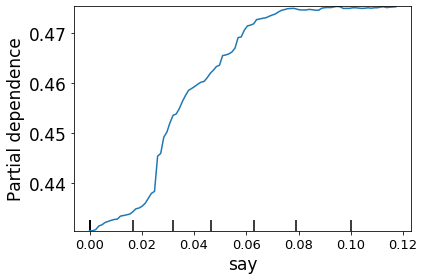

In [136]:
# Partial Dependence Plot (reduce features or else breaks kernel)
plot_partial_dependence(rfc, tfidf_X_train_df.sample(frac=.1), ['say'], n_jobs=-1)
fig = plt.gcf()
plt.tight_layout()

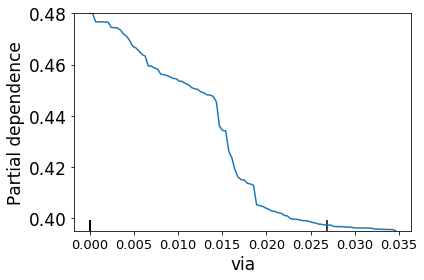

In [137]:
# Partial Dependence Plot (reduce features or else breaks kernel)
plot_partial_dependence(rfc, tfidf_X_train_df.sample(frac=.1), ['via'], n_jobs=-1)
fig = plt.gcf()
plt.tight_layout()

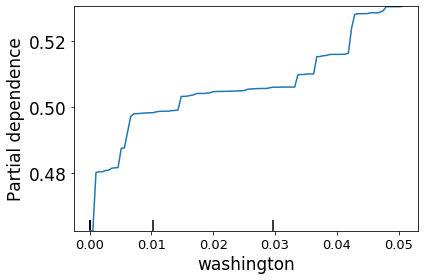

In [138]:
# Partial Dependence Plot (reduce features or else breaks kernel)
plot_partial_dependence(rfc, tfidf_X_train_df.sample(frac=.1), ['washington'], n_jobs=-1)
fig = plt.gcf()
plt.tight_layout()

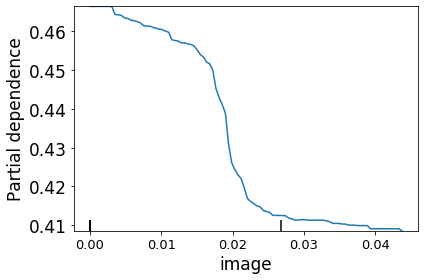

In [139]:
# Partial Dependence Plot (reduce features or else breaks kernel)
plot_partial_dependence(rfc, tfidf_X_train_df.sample(frac=.1), ['image'], n_jobs=-1)
fig = plt.gcf()
plt.tight_layout()

In [231]:
false_ex = ['president trump declared war on the whole world today']
false_ex = tfidf.transform(false_ex)
rfc.predict_proba(false_ex)

array([[0.89931196, 0.10068804]])

In [256]:
nyt_ex = ['''For the first three years of President Trump’s time in office, his blunt-force view of the military was confined to threatening American adversaries: \
          “fire and fury” if North Korea challenged American troops. A warning that he would “shoot down and destroy” Iranian forces in the Persian Gulf. Billions \
          spent to rejuvenate a nuclear arsenal he viewed as the ultimate source of American power.His generals and admirals accepted a commander in chief with what \
          they diplomatically dismissed as a “unique style” — and they welcomed the increase in military spending. His chief diplomats, while embarrassed, saw some \
          utility in trying to force adversaries to the table. Now, that tolerance has frayed. Mr. Trump’s threat to use the 1807 Insurrection Act to send active-duty \
           troops on American soil against protesters has laid bare the chasm in the national security community that was forming even when he ran for \ 
           office in 2016.Back then it was only a limited group of “Never Trumpers” — establishment Republican national security professionals repelled \ 
           by Mr. Trump’s description of how American power should be wielded around the world — who wrote and spoke of the dangers. He “lacks the character, \ 
           values and experience” to be president, they wrote, and “would put at risk our country’s national security.”This week, it was his former defense secretary, \ 
           a former chairman of the Joint Chiefs of Staff and a range of other retired senior officers who were saying in public what they previously said only in private: \
            that the risk lies in the fact that the president regards the military, which historically has prized its nonpartisan, apolitical role in society, as just another \ 
            political force to be massed to his advantage.“There is a thin line between the military’s tolerance for questionable partisan moves over the past three years and \
            the point where these become intolerable for an apolitical military,” said Douglas E. Lute, a retired three-star Army general who coordinated Afghanistan and \ 
            Pakistan operations on the National Security Council for Presidents George W. Bush and Barack Obama, and later became the American ambassador to NATO. \ 
            “Relatively minor episodes have accumulated imperceptibly, but we are now at a point of where real damage is being done.''']
nyt_ex = tfidf.transform(nyt_ex)
rfc.predict_proba(nyt_ex)

array([[0.42, 0.58]])

### Testing on "extra" data (unknown source, but labeled)

In [92]:
X_extra_tfidf = tfidf.transform(X_extra)

In [93]:
rfc_y_hat = rfc.predict(X_extra_tfidf)

In [94]:
accuracy_score(y_extra, rfc_y_hat)

0.6601420678768745

### Definitely some improvement! With more data, the RFC went from 59% accuracy to 66% accuracy on unknown outside source news

In [52]:
df_all.head()

,text,label
0,Donald Trump just couldn t wish all Americans ...,0
1,House Intelligence Committee Chairman Devin Nu...,0
2,"On Friday, it was revealed that former Milwauk...",0
3,"On Christmas day, Donald Trump announced that ...",0
4,Pope Francis used his annual Christmas Day mes...,0


In [55]:
# clean df_all
df_all_clean = df_all.copy()
df_all_clean['text'] = df_all_clean['text'].apply(lambda x: preprocessor(x))

In [56]:
real = df_all_clean[df_all_clean.label == 1]
fake = df_all_clean[df_all_clean.label == 0]

In [216]:
# Word Cloud needs one long string of words

real_text = ' '.join(text for text in real.text)

In [ ]:
# Word Cloud needs one long string of words

fake_text = ' '.join(text for text in fake.text)

In [217]:
# wordcloud = WordCloud(width = 800, height = 600, 
#                 background_color ='white', 
#                 stopwords = sw + ['reuters'], 
#                 min_font_size = 10).generate(real_text) 
  
# # plot the WordCloud image                        
# plt.figure(figsize = (8, 8), facecolor = None) 
# plt.imshow(wordcloud) 
# plt.axis("off") 
# plt.tight_layout(pad = 0) 
  
# plt.show()

In [64]:
df_all[65000:65010]

,text,label
65000,Gov. Mary Fallin of Oklahoma vetoed a bill on ...,1
65001,ISTANBUL — Lawmakers from President Recep T...,1
65002,Come summer (and what is Memorial Day weekend ...,1
65003,A powerful array of the Republican Party’s lar...,1
65004,Donald J. Trump has faced a chilly reception f...,1
65005,Doubling down on his feud with the Democratic ...,1
65006,"CAIRO — In an eerie coincidence, the EgyptA...",1
65007,"PRISTINA, Kosovo — Every Friday, just yards...",1
65008,"BALTIMORE — They are Louisiana horsemen, Ke...",1
65009,Growing up as a member of the Gila River India...,1
